In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import pandas as pd

def clean_mbta_reliability(file_path):
    """
    Cleans the MBTA reliability dataset with a focus on bus data for
    performance and equity analysis.

    Args:
        file_path (str): The file path to the raw CSV data.

    Returns:
        pandas.DataFrame: A cleaned DataFrame.
    """

    # Load Data
    # Load the dataset
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

    print(f"Original data shape: {df.shape}")

    # Filter for Bus Data
    # Keep only 'Bus' data.
    df_bus = df[df['mode_type'] == 'Bus'].copy()
    print(f"Shape after filtering for 'Bus': {df_bus.shape}")


    # Handle Dates
    # Convert service_date to datetime objects for filtering and feature engineering
    df_bus['service_date'] = pd.to_datetime(df_bus['service_date'])

    # Filter for project's time frame (2018-present)
    df_bus = df_bus[df_bus['service_date'] >= '2018-01-01'].copy()
    print(f"Shape after filtering for dates >= 2018: {df_bus.shape}")


    # Handle Missing Values
    # Check for missing values
    # print("\n--- Missing Value Counts ---")
    # print(df_bus.isnull().sum())

    # 'cancelled_numerator' might have NaNs, which means 0 cancellations.
    # Assuming NaN = 0.
    df_bus['cancelled_numerator'] = df_bus['cancelled_numerator'].fillna(0)

    # If otp_denominator is null, the row is useless.
    df_bus = df_bus.dropna(subset=['otp_numerator', 'otp_denominator'])
    print(f"Shape after dropping key nulls: {df_bus.shape}")


    # Calculate reliability metric

    # Avoid division by zero. If denominator is 0, reliability is undefined (NaN).
    df_bus['reliability_metric'] = df_bus['otp_numerator'] / df_bus['otp_denominator']

    # Handle cases where division resulted in NaN (e.g., 0/0)
    # If 0/0, it means no service was observed, so no reliability score.
    # We can't say it was 100% reliable. Dropping these may be best.
    df_bus = df_bus.dropna(subset=['reliability_metric'])




    # Select and rename columns
    # Keep only the columns relevant to analysis
    relevant_cols = [
        'service_date',
        'gtfs_route_id',
        'gtfs_route_short_name',
        'route_category',
        'peak_offpeak_ind',
        'metric_type',
        'otp_numerator',
        'otp_denominator',
        'reliability_metric',
        'cancelled_numerator'
    ]

    # Ensure all desired columns exist before trying to select them
    final_cols = [col for col in relevant_cols if col in df_bus.columns]
    df_cleaned = df_bus[final_cols].copy()

    print(f"Final cleaned data shape: {df_cleaned.shape}")

    return df_cleaned

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

def plot_static_timeseries(cleaned_df):
    """
    Creates a static time-series plot of bus reliability using matplotlib.
    """
    # Resample by month ('ME') to get a smoother trend
    # We group by 'peak_offpeak_ind' first, then resample each group
    df_monthly = (
        cleaned_df.set_index('service_date')
        .groupby('peak_offpeak_ind')['reliability_metric']
        .resample('ME')
        .mean()
        .reset_index()
    )

    # Pivot the data for easier plotting (PEAK and OFF_PEAK as columns)
    df_pivot = df_monthly.pivot(
        index='service_date',
        columns='peak_offpeak_ind',
        values='reliability_metric'
    )

    # Create the Plot
    print("Generating plot...")
    fig, ax = plt.subplots(figsize=(15, 9))

    # Instead of df_pivot.plot(), we use ax.plot() directly
    # This gives matplotlib explicit control over the date axis
    ax.plot(df_pivot.index, df_pivot['OFF_PEAK'], '.-', markersize=4, label='OFF_PEAK')
    ax.plot(df_pivot.index, df_pivot['PEAK'], '.-', markersize=4, label='PEAK')

    # Add Formatting

    # Add a vertical line for the pandemic
    pandemic_date = pd.to_datetime('2020-03-01')
    ax.axvline(pandemic_date, color='red', linestyle='--', label='Pandemic Start (Mar 2020)')

    # Set titles and labels
    ax.set_title('Average Monthly Bus Reliability (2018-Present)', fontsize=16)
    ax.set_ylabel('Reliability', fontsize=12)
    ax.set_xlabel('Year', fontsize=12)

    # Format Y-axis as percentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax.set_ylim(0.4, 1.0) # Adjust as needed to see variation

    # Set major ticks to appear every 6 months
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

    # Set the format of the major labels to 'YYYY-MM' (e.g., "2019-01")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Set minor ticks to appear every month (without labels)
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    # Rotate the X-axis labels to prevent overlap
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Add legend and grid
    ax.legend(title='Time Period')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout() # Adjust plot to prevent label overlap

    # Save the Plot
    plot_filename = 'static_reliability_timeseries.png'
    plt.savefig(plot_filename)
    print(f"\nSuccess! Plot saved to {plot_filename}")

def plot_bottom_5_reliability_routes(cleaned_df):
    """
    Finds the 5 routes with the lowest average reliability
    and plots their time-series data in a small-multiple chart.
    """

    # Find the 5 best routes
    # We use 'gtfs_route_short_name' as it's human-readable (e.g., "39")
    avg_reliability = cleaned_df.groupby('gtfs_route_short_name')['reliability_metric'].mean()
    bottom_5_routes = avg_reliability.sort_values().tail(5)

    bottom_5_route_names = bottom_5_routes.index

    # Prepare data for plotting
    # Filter main dataframe to only these 5 routes
    df_filtered = cleaned_df[cleaned_df['gtfs_route_short_name'].isin(bottom_5_route_names)]

    # Resample this data by month
    df_monthly = (
        df_filtered.set_index('service_date')
        .groupby(['gtfs_route_short_name', 'peak_offpeak_ind'])['reliability_metric']
        .resample('ME')
        .mean()
    ).reset_index()

    # Pivot for easier plotting
    df_pivot = df_monthly.pivot_table(
        index=['service_date', 'gtfs_route_short_name'],
        columns='peak_offpeak_ind',
        values='reliability_metric'
    ).reset_index()

    #Create the "Small Multiples" Plot

    # Create 5 subplots, stacked vertically (5 rows, 1 column)
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20), sharex=True, sharey=True)

    pandemic_date = pd.to_datetime('2020-03-01')

    # Loop through each route and its assigned subplot (ax)
    for i, route_name in enumerate(bottom_5_route_names):
        ax = axes[i]

        # Get data for just this one route
        route_data = df_pivot[df_pivot['gtfs_route_short_name'] == route_name]

        # Plot PEAK and OFF_PEAK
        ax.plot(route_data['service_date'], route_data['OFF_PEAK'], '.-', label='OFF_PEAK')
        ax.plot(route_data['service_date'], route_data['PEAK'], '.-', label='PEAK')

        # Add pandemic line
        ax.axvline(pandemic_date, color='red', linestyle='--', label='Pandemic Start (Mar 2020)')

        # Formatting
        # Add a title to each subplot
        ax.set_title(f"Route: {route_name}", fontsize=14, loc='left')
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Format Y-axis as percentage
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    # Final Global Formatting
    # Set a shared Y-axis label
    fig.text(0.04, 0.5, 'Reliability', va='center', rotation='vertical', fontsize=12)

    # Set a shared X-axis label (only on the bottom plot)
    ax.set_xlabel('Month and Year', fontsize=12)

    # Set shared X-axis date formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Set a single main title for the whole figure
    fig.suptitle('Monthly Reliability for 5 best-Performing Routes', fontsize=20, y=1.02)

    plt.tight_layout() # Adjust plots to prevent label overlap

    # Save the Plot
    plot_filename = 'bottom_5_routes_timeseries.png'
    plt.savefig(plot_filename, bbox_inches='tight') # bbox_inches ensures title isn't cut off

Original data shape: (979208, 13)
Shape after filtering for 'Bus': (850885, 13)
Shape after filtering for dates >= 2018: (648505, 13)
Shape after dropping key nulls: (648505, 13)
Final cleaned data shape: (646596, 10)
Generating plot...

Success! Plot saved to static_reliability_timeseries.png


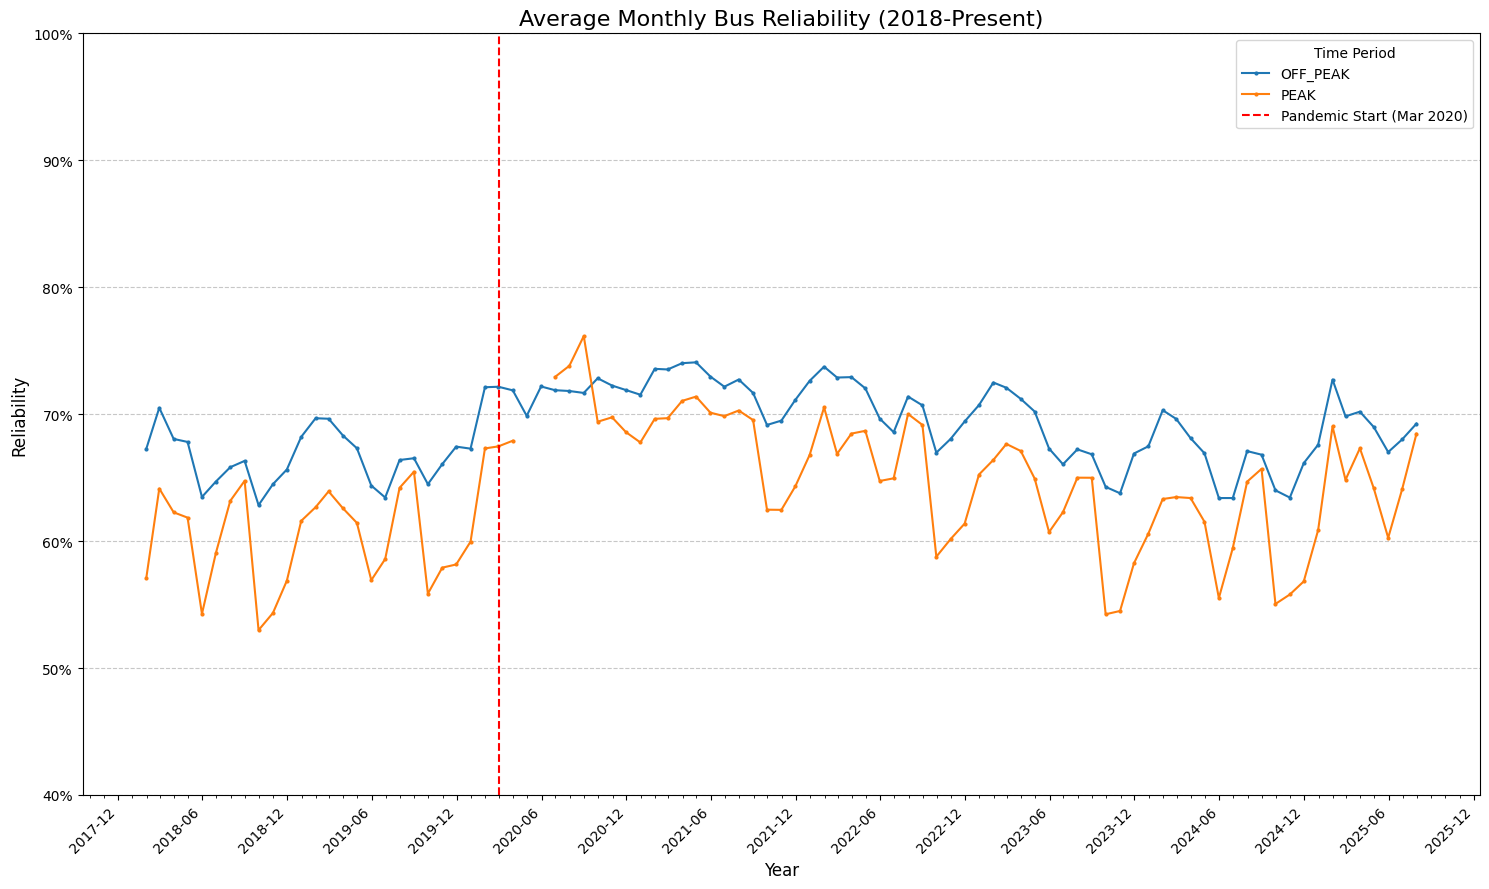

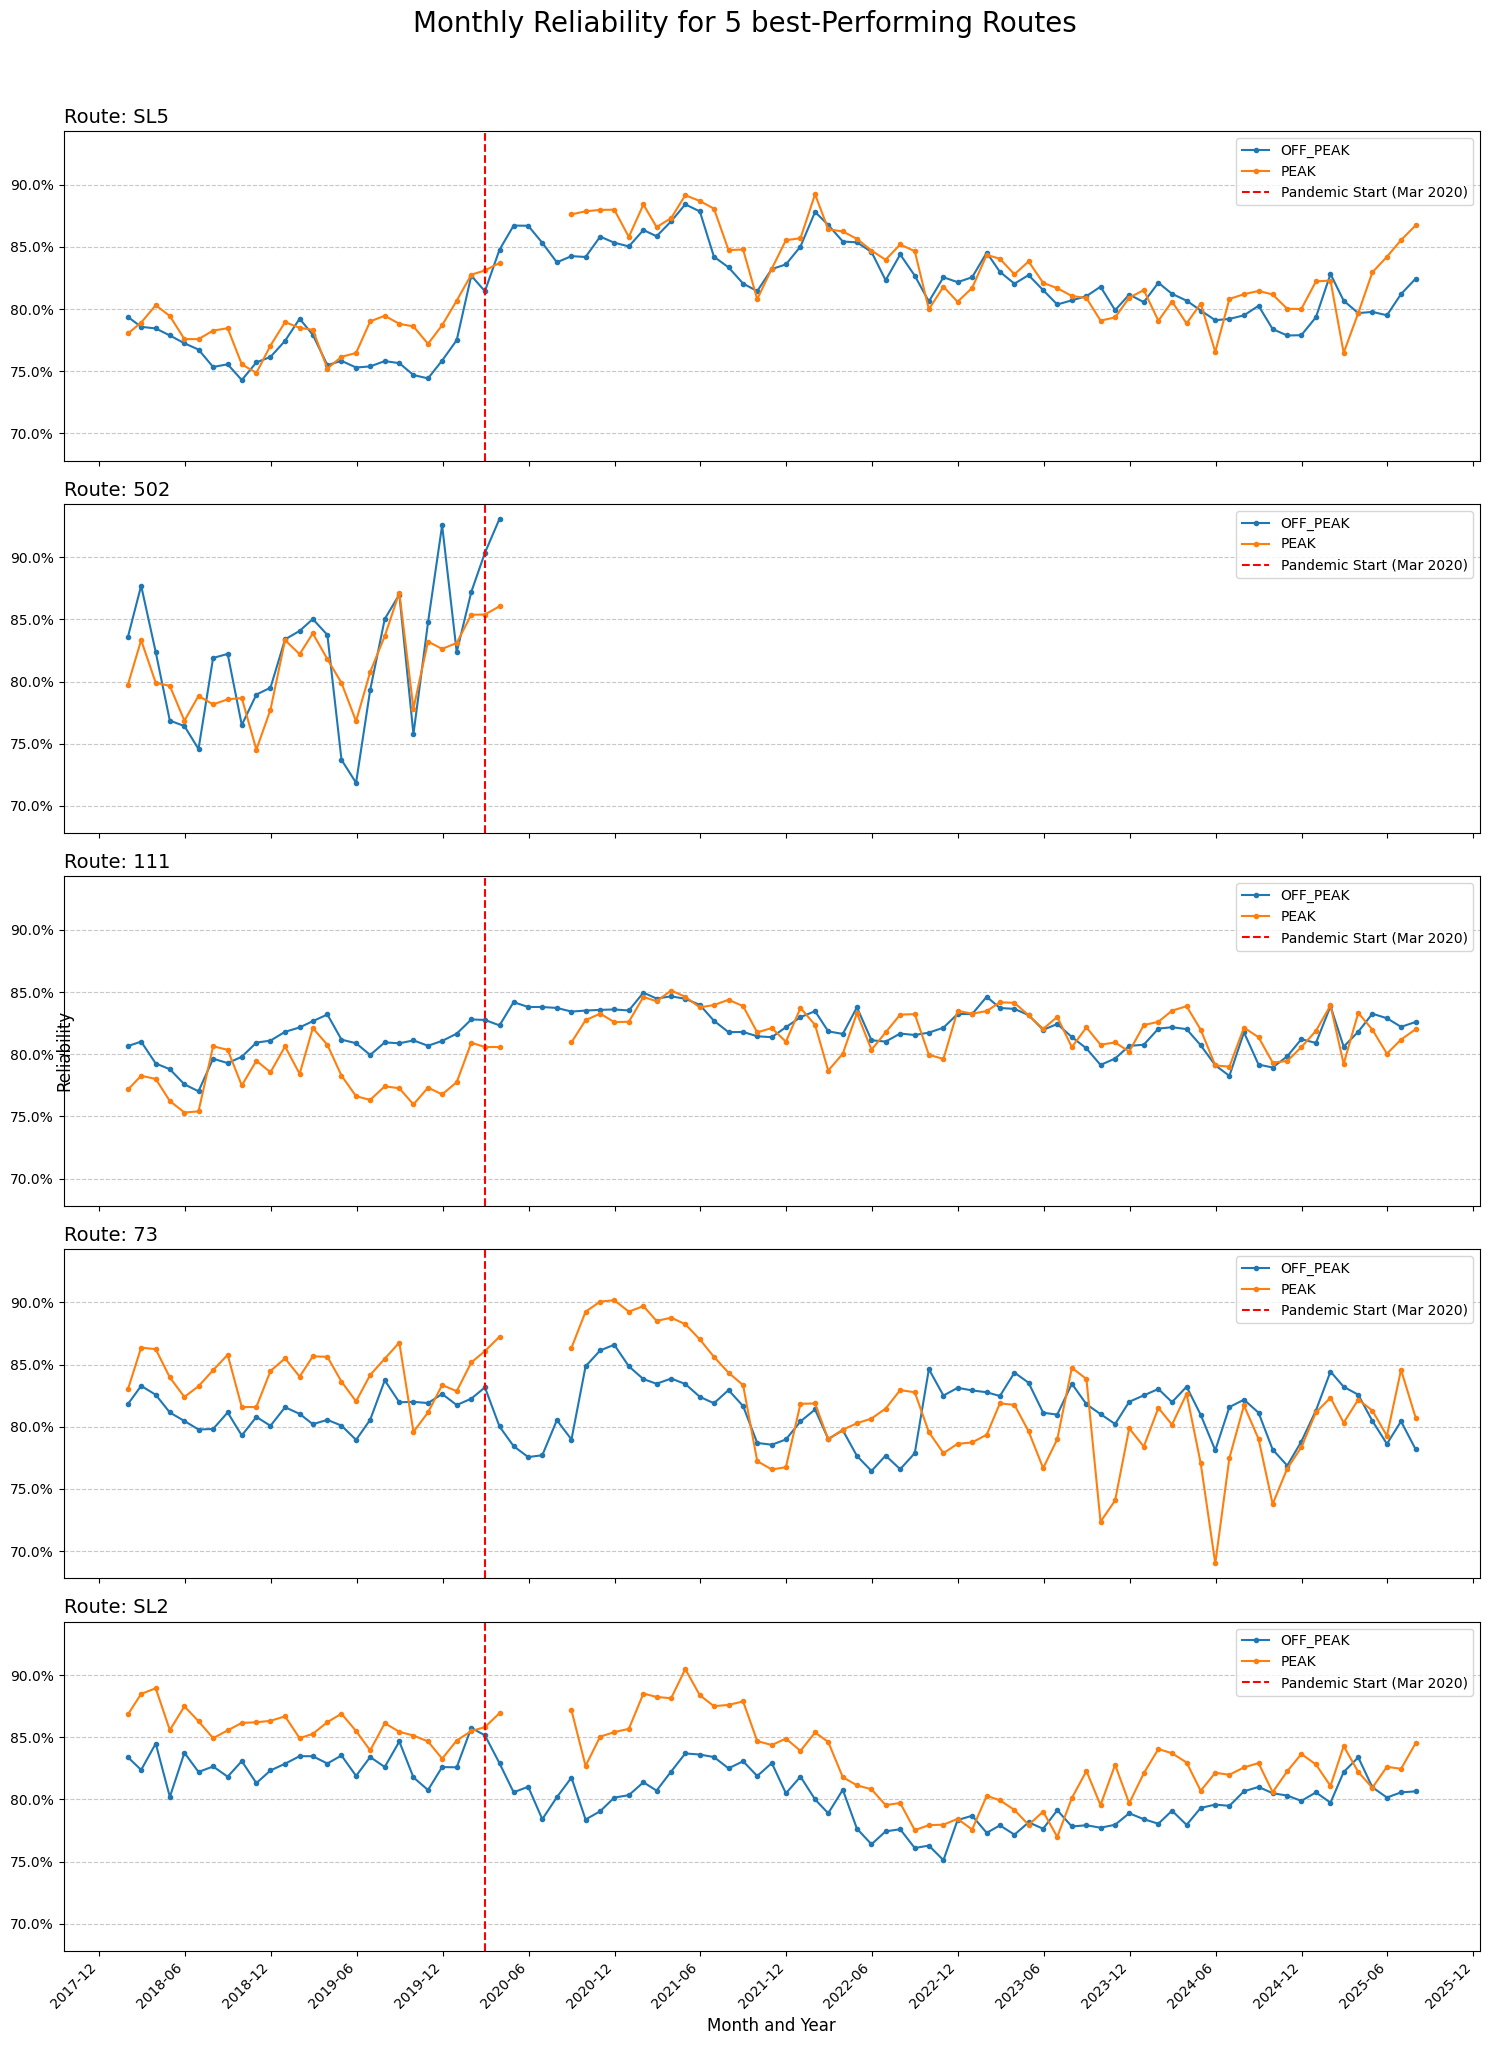

In [20]:
import os

file_path = '/content/drive/MyDrive/CS506/data/reliability/MBTA_Bus_CommuterRail_RapidTransit_Reliability.csv'
cleaned_bus_data = clean_mbta_reliability(file_path)

# Save the filtered DataFrame to a new CSV file
if cleaned_bus_data is not None:
    output_dir = os.path.dirname(file_path)
    output_path = os.path.join(output_dir, 'clean_mtba_bus_reliability.csv')
    # Line commented to not overwrite the csv file every time
    #cleaned_bus_data.to_csv(output_path, index=False)
    plot_static_timeseries(cleaned_bus_data)
    plot_bottom_5_reliability_routes(cleaned_bus_data)
    #plot_interactive_route_explorer(cleaned_bus_data)
else:
    print("Cleaning failed, data not saved.")